In [87]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import bokeh.palettes as palette # For palette of colors
import time
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
import os

%matplotlib inline

In [88]:
path1='optical_absorbance_data/Bulk_Au.dat'
col1=pd.read_csv(path1, sep='\s+', nrows=1, header=None).iloc[0].values[0:]
diel_data=pd.read_csv(path1,sep='\s+',skiprows=1,header=None,names=col1)

diel_data = diel_data.sort_values('lam(nm)',ascending=False)

diel_data['lam(nm)'] = diel_data['lam(nm)'].astype(float)

In [89]:
path2='optical_absorbance_data/AuNP.txt'
col2=pd.read_csv(path2, sep='\s+', skiprows=18, nrows=1, header=None).iloc[0].values[0:]
np_data=pd.read_csv(path2,sep='\s+',skiprows=19,header=None,names=col2)
np_data_filtered=np_data[np_data['lam(nm)']>=400] 
np_data_filtered=np_data_filtered[np_data_filtered['lam(nm)']<=800] 

In [90]:
path3='optical_absorbance_data/HAuCl4.txt'
col3=pd.read_csv(path3, sep='\s+', skiprows=18, nrows=1, header=None).iloc[0].values[0:]
acid_data=pd.read_csv(path3,sep='\s+',skiprows=19,header=None,names=col3)

In [91]:
acid_data=acid_data[acid_data['lam(nm)']<=800]

In [92]:
diel_data = diel_data[ diel_data['lam(nm)']>=min(np_data['lam(nm)'])]
diel_data = diel_data[diel_data['lam(nm)']<=800.0]

In [93]:
new_dataframe = {'lam(nm)' : np.array(diel_data['lam(nm)']),
                 'abs'     : np.array(np_data_filtered['abs']),
                 'eps1'    : np.array(diel_data['eps1']),
                 'eps2'    : np.array(diel_data['eps2'])}
                 
np_data = pd.DataFrame(new_dataframe) 

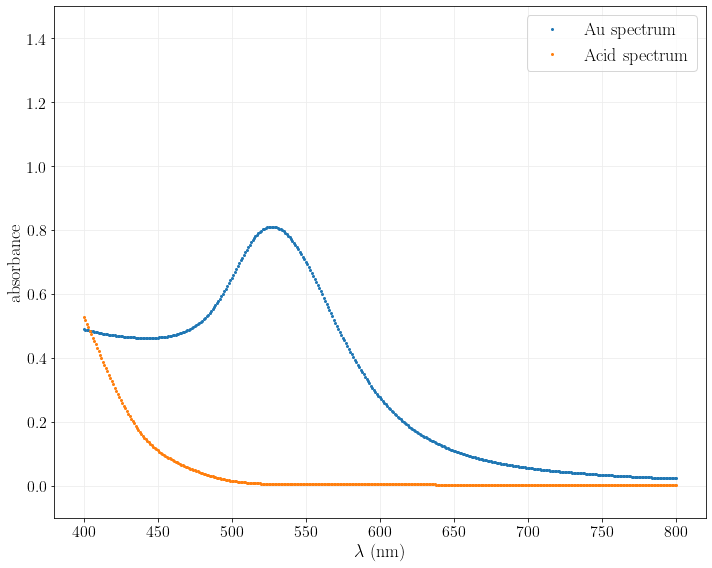

In [94]:
# Plot of experimental results
fig, (ax2) = plt.subplots(1, 1, figsize=(10,8))

ax2.plot(np_data['lam(nm)'],np_data['abs'],'.',markersize=4,label='Au spectrum')
ax2.plot(acid_data['lam(nm)'],acid_data['abs'],'.',markersize=4,label='Acid spectrum')


#ax2.set_title(r'Plot of absorbtion as a function of the wavelength',fontsize=16)
ax2.set_xlabel(r'$\lambda$ (nm)',fontsize=18)
ax2.set_ylabel(r'absorbance',fontsize=18)
ax2.grid(color='0.93')
ax2.legend(fontsize=18,title_fontsize=18,loc='upper right')
ax2.tick_params(axis="x", labelsize=16)
ax2.tick_params(axis="y", labelsize=16)
ax2.set_ylim(-0.1,1.50)

if not os.path.isdir('./images'):
        os.mkdir('./images')
        
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.tight_layout()
plt.savefig('images/exp_data.pdf', format='pdf')

In [95]:
# CONSTANTS
e          = 1.6 * np.power(1/10,19)  # Electron charge
n          = 5.90 * np.power(10.,28)   # Density of free electrons in Au
eps0       = 8.85 * np.power(1/10,12) # Dielectric function of void
me         = 9.11 * np.power(1/10,31) # Mass electron
m0         = 0.99                     # Efficancy mass

hbar       = 6.58 * np.power(1/10,16)
c_speed    = 3. * np.power(10.,8) * np.power(10,9)    # speed of light [nm/s]

omega_p    = np.sqrt( n*e*e/(m0*me*eps0) )                        # plasmon frequency [Hz]

gamma_bulk = 1/(9.3*np.power(1/10,15))                            # gamma bulk [Hz]
v_f        = 1.4 * np.power(10.,6) * np.power(10.,9)  # Fermi velocity 

print('omega p   :', omega_p)
print('gamma bulk:', gamma_bulk)

# Define the function gamma_R
def gamma_R(R):
    return gamma_bulk + np.pi/4 * v_f * 1/R

# Function correction of size to the dielectric function
# eps1
def eps_1_corr(eps1,omega,R):
    eps_1_corr = eps1 + np.power(omega_p,2) * (  1/( np.power(omega,2) + np.power(gamma_bulk,2) ) 
                                               - 1/( np.power(omega,2) + np.power(gamma_R(R),2) )  )
    return eps_1_corr
# eps2
def eps_2_corr(eps2,omega,R):
    eps_2_corr = eps2 - np.power(omega_p,2)/omega  * (  gamma_bulk/( np.power(omega,2) + np.power(gamma_bulk,2) ) 
                                                      - gamma_R(R)/( np.power(omega,2) + np.power(gamma_R(R),2) )  )
    return eps_2_corr


omega p   : 1.3756171048718256e+16
gamma bulk: 107526881720430.02


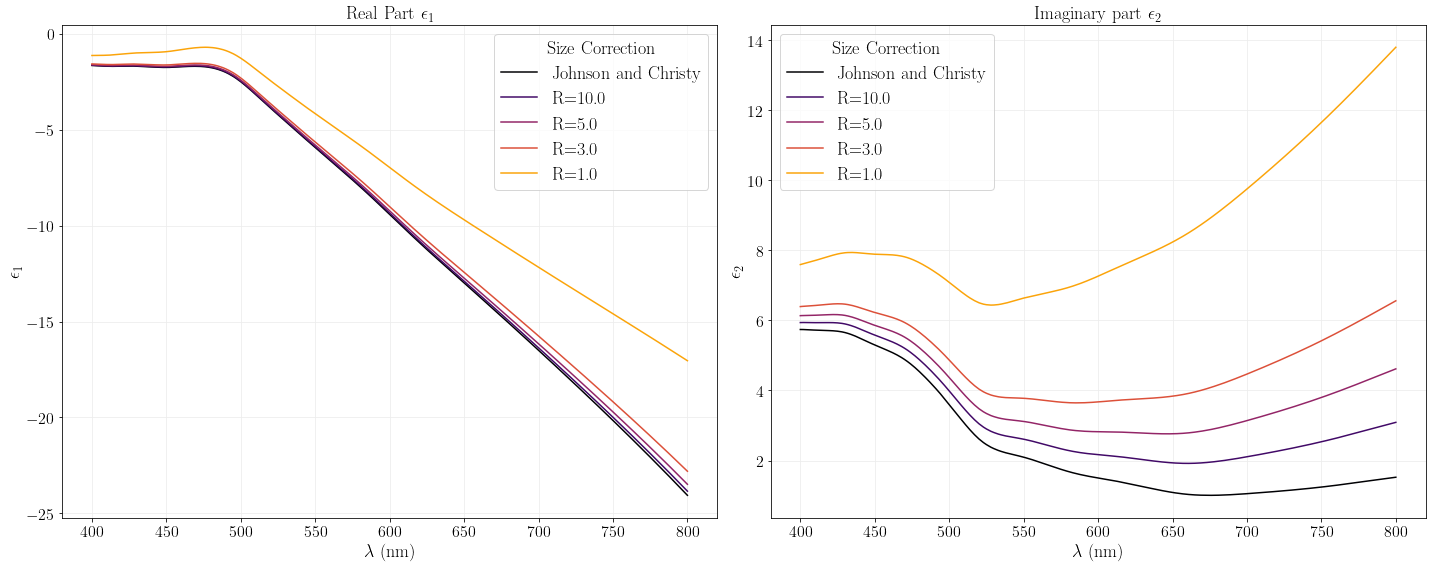

In [96]:
# Compute values of eps1 and eps2 corrected
x     = np.array( np_data['lam(nm)'] ) 
eps_1 = np.array( np_data['eps1'] )
eps_2 = np.array( np_data['eps2'] )

omega = 2 * np.pi * c_speed / x


R         = [10,5,3,1]
eps1_list = []
eps2_list = []

for i in R:
    eps1_list.append( eps_1_corr(eps_1,omega,i) )
    eps2_list.append( eps_2_corr(eps_2,omega,i) )
    
# Plot of eps1 and eps2 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

col = palette.inferno(len(R)+2)

ax1.plot(np_data['lam(nm)'],np_data['eps1'],'',color=col[0],label='Johnson and Christy')

for i in range(len(R)):
    ax1.plot(np_data['lam(nm)'],eps1_list[i],'',color=col[i+1],label='R={0:2.1f}'.format(R[i]))

ax1.set_title(r'Real Part $\epsilon_1$',fontsize=18)
ax1.set_xlabel(r'$\lambda$ (nm)',fontsize=18)
ax1.set_ylabel(r'$\epsilon_1$',fontsize=18)
ax1.grid(color='0.93')
ax1.legend(title='Size Correction',fontsize=18,title_fontsize=18,loc='upper right')
ax1.tick_params(axis="x", labelsize=16)
ax1.tick_params(axis="y", labelsize=16)

ax2.plot(np_data['lam(nm)'],np_data['eps2'],'',color=col[0],label='Johnson and Christy')

for i in range(len(R)):
    ax2.plot(np_data['lam(nm)'],eps2_list[i],'',color=col[i+1],label='R={0:2.1f}'.format(R[i]))

ax2.set_title(r'Imaginary part $\epsilon_2$',fontsize=18)
ax2.set_xlabel(r'$\lambda$ (nm)',fontsize=18)
ax2.set_ylabel(r'$\epsilon_2$',fontsize=18)
ax2.grid(color='0.93')
ax2.legend(title='Size Correction',fontsize=18,title_fontsize=18,loc='best')
ax2.tick_params(axis="x", labelsize=16)
ax2.tick_params(axis="y", labelsize=16)


if not os.path.isdir('./images'):
        os.mkdir('./images')
        
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.tight_layout()
plt.savefig('images/size_correction.pdf', format='pdf')


In [97]:
# Limit the fit range 
np_data_f = np_data[np_data['lam(nm)']>= 350]  
np_data_f = np_data_f[np_data_f['lam(nm)']<= 650]

min chi_square: 0.3010937687358103
index min chi_square index: 2698
a= 4.05050505050505
b= 9.90909090909091
Centroid: 523.0
1.444060566191731


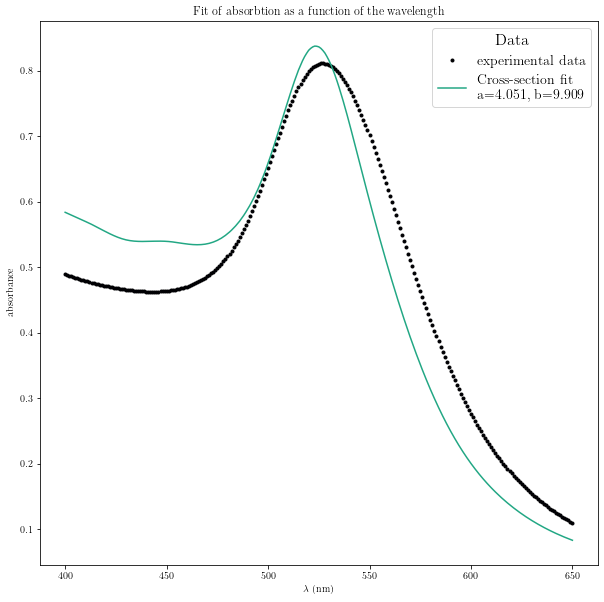

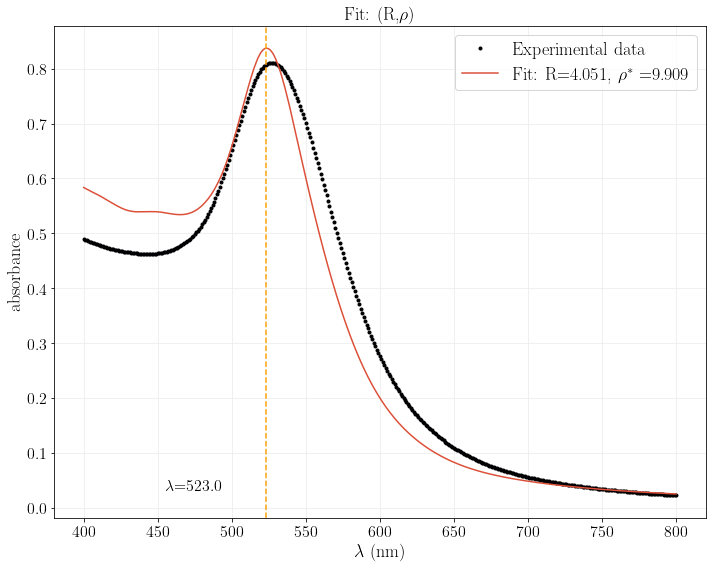

In [98]:
# R and rho

#Define the function for the fit R and rho
def cross_section_rho(x,a,b,bool_lim=False):  # a = R, b=rho
    
    omega = 2 * np.pi * c_speed / x
    
    epsm = 1.33**2#1.43*1.43 #1.33*1.33 

    constant = np.log10(np.e) * 9/c_speed * 4/3 * np.pi * np.power(10.,7) * np.power(1/10,9) # L'ultimo valore è in piùùùù
    
    if bool_lim==True:
        eps_1 = np.array( np_data_f['eps1'] )
        eps_2 = np.array( np_data_f['eps2'] )
    if bool_lim==False:
        eps_1 = np.array( np_data['eps1'] )
        eps_2 = np.array( np_data['eps2'] )
        
    eps1 = eps_1_corr(eps_1,omega,a)
    eps2 = eps_2_corr(eps_2,omega,a)
    
    sigma = constant * np.power(epsm,3/2) * np.power(a,3) * b * omega * np.divide(eps2, np.power(eps1+2*epsm,2) + np.power(eps2,2) )
    
    return sigma

#R_list = np.linspace(3, 10, num=100)
R_list = np.linspace(3, 7, num=100)
rho_list = np.linspace(1,10, num=100)

x = np.array( np_data_f['lam(nm)'] )
y = np.array( np_data_f['abs'] )

error = 1/y

chi_list = [] 
a_list   = []
b_list   = []


for i in range(len(R_list)):
    for j in range(len(rho_list)):
        chisq = np.sum( np.power( y - cross_section_rho(x,R_list[i],rho_list[j],bool_lim=True), 2)  /(np.power(error,2)) )
        
        chi_list.append(chisq)
        a_list.append(R_list[i])
        b_list.append(rho_list[j])

        
min_chi       =  min(chi_list)
index_min_chi = np.argmin(chi_list)
a             = a_list[index_min_chi]
b             = b_list[index_min_chi]

print('min chi_square:', min_chi)
print('index min chi_square index:', index_min_chi)
print('a=',a)
print('b=',b)

# Plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10,10))

ax1.plot(x,y,'.',color=palette.inferno(6)[0], label= 'experimental data')
string= 'Cross-section fit \n a='+str(round(a,3))+', b='+str(round(b,3))
ax1.plot(x,cross_section_rho(x,a,b,bool_lim=True),'',color=palette.viridis(6)[3], label=string)

ax1.legend(title='Data',fontsize=14,title_fontsize=16,loc='upper left')
ax1.set_title('Fit of absorbtion as a function of the wavelength')
ax1.set_xlabel('$\lambda$ (nm)')
ax1.set_ylabel('absorbance')
ax1.grid(color='0.93')

ax1.legend(title='Data',fontsize=14,title_fontsize=16,loc='upper right')
ax1.set_title('Fit of absorbtion as a function of the wavelength')
ax1.set_xlabel('$\lambda$ (nm)')
ax1.set_ylabel('absorbance')
ax1.grid(color='0.93')



## Plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10,8))
#
ax1.plot(np_data['lam(nm)'],np_data['abs'],'.',color=palette.inferno(6)[0], label= 'Experimental data')
string= 'Fit:  R='+str(round(a,3))+', $\\rho^*$ ='+str(round(b,3))
#ax1.plot(np_data['lam(nm)'],cross_section_rho(np_data['lam(nm)'], 5.3,4.05),'',color='red',label=string)
#ax1.plot(np_data['lam(nm)'],cross_section_rho(np_data['lam(nm)'], 6.6,2.),'',color=palette.viridis(6)[3],label=string)
ax1.plot(np_data['lam(nm)'],cross_section_rho(np_data['lam(nm)'], a, b),'',color=palette.inferno(6)[3],label=string)
ax1.legend(fontsize=18,title_fontsize=18,loc='best')
ax1.set_title('Fit: (R,$\\rho$)',fontsize=18)
ax1.set_xlabel(r'$\lambda$ (nm)',fontsize=18)
ax1.set_ylabel(r'absorbance',fontsize=18)
ax1.grid(color='0.93')
ax1.tick_params(axis="x", labelsize=16)
ax1.tick_params(axis="y", labelsize=16)

# Max centroid
id_centr = np.argmax(cross_section_rho(np_data['lam(nm)'], a, b))
centr = np_data['lam(nm)'][id_centr]
print('Centroid:', centr)
ax1.axvline(x=centr,ls='--',color=palette.inferno(6)[4])
s = '$\\lambda$='+ str(centr)
plt.text(455, 0.03, s, fontsize=16)

if not os.path.isdir('./images'):
        os.mkdir('./images')
        
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.tight_layout()
plt.savefig('images/1_fit.pdf', format='pdf')


val = np.sum( np.power( y - cross_section_rho(x,5.9,3.6,bool_lim=True), 2)  /(np.power(error,2)) )
print(val)

In [99]:
np.std(b_list)

2.624188186156556

In [100]:
A_grid, B_grid = np.meshgrid(R_list, rho_list)

chisq_values = np.zeros((len(A_grid),len(B_grid)))

for i in range(len(A_grid)):
    for j in range(len(B_grid)):
        chisq = np.sum( np.power( y - cross_section_rho(x,A_grid[i][j],B_grid[i][j],bool_lim=True), 2)/(np.power(error,2)) )
        chisq_values[i][j] = chisq
        

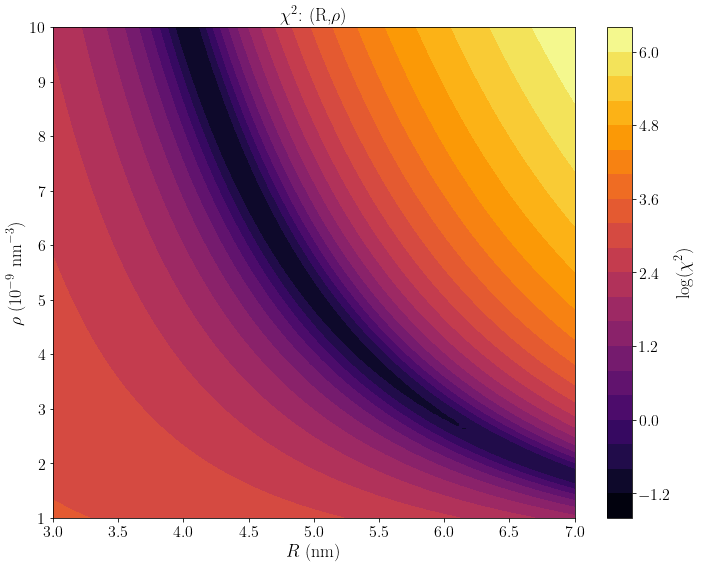

In [101]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10,8))
cp = ax1.contourf(np.array(A_grid), np.array(B_grid), np.log(chisq_values), levels=20, cmap='inferno')
                  #norm=colors.LogNorm(vmin=chisq_values.min(), vmax=chisq_values.max()))

#norm=colors.LogNorm(vmin=chisq_values.min(), vmax=chisq_values.max())
#ax1.set_yscale('log')

#ax1.legend(fontsize=18,title_fontsize=18,loc='best')
ax1.set_title('$\\chi^2$: (R,$\\rho$)',fontsize=18)
ax1.set_xlabel('$R$ (nm)',fontsize=18)
ax1.set_ylabel('$\\rho$ $(10^{-9}$ nm$^{-3})$',fontsize=18)
#ax1.grid(color='0.93')
ax1.tick_params(axis="x", labelsize=16)
ax1.tick_params(axis="y", labelsize=16)

colbar = plt.colorbar(cp)
colbar.set_label('$\\log(\\chi^2)$',fontsize=18)
colbar.ax.tick_params(labelsize=16)

if not os.path.isdir('./images'):
        os.mkdir('./images')
        
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.tight_layout()
plt.savefig('images/1_chisquare.pdf', format='pdf')

In [102]:
R = a
rho = b

min chi_square: 0.07534907515436295
index min chi_square index: 4936
a= 3.7323232323232323
b= 1.4363636363636365
Centroid: 529.0


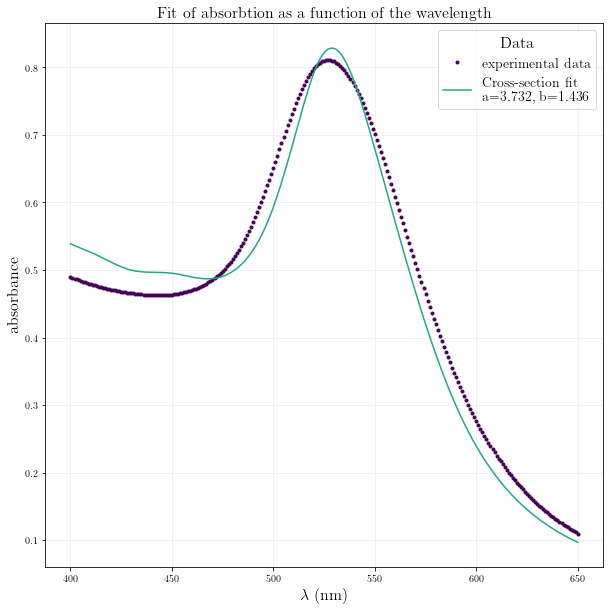

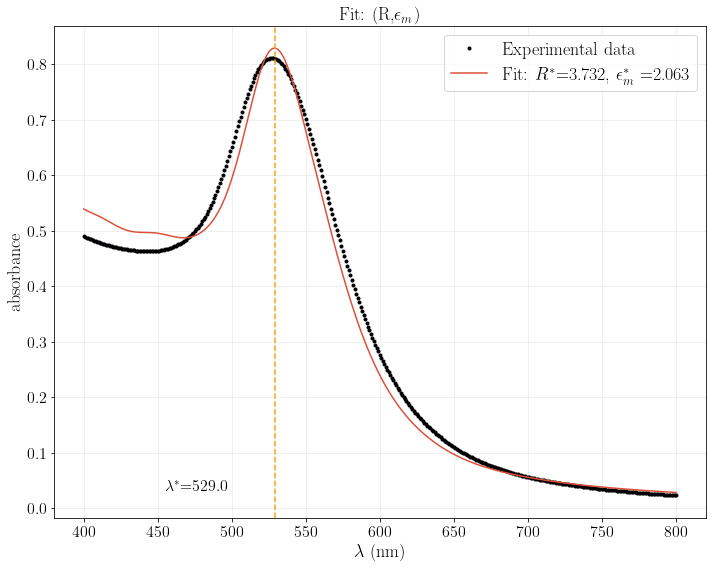

In [103]:
# R and Epsm

#Define the function for the fit R and epsm
def cross_section_epsm(x,a,b,val_rho,bool_lim=False):  # a = R, b = epsm
    
    omega = 2 * np.pi * c_speed / x
    
    rho = val_rho * np.power(1/10,9) # VALORE INSERITO IN PIUUU
    
    constant = np.log10(np.e) * 9/c_speed * 4/3 * np.pi * np.power(10,7) 
    
    if bool_lim==True:
        eps_1 = np.array( np_data_f['eps1'] )
        eps_2 = np.array( np_data_f['eps2'] )
    if bool_lim==False:
        eps_1 = np.array( np_data['eps1'] )
        eps_2 = np.array( np_data['eps2'] )
    
    eps1 = eps_1_corr(eps_1,omega,a)
    eps2 = eps_2_corr(eps_2,omega,a)
    
    sigma = constant * rho * np.power(a,3) * omega * np.power((b**2),3/2) * np.divide(eps2, np.power(eps1+2*(b**2),2) + np.power(eps2,2) )
    
    return sigma


R_list = np.linspace(2., 5.5, num=100)
epsm_list = np.linspace(1.,2.2, num=100)

x = np.array( np_data_f['lam(nm)'] )
y = np.array( np_data_f['abs'] )

error = 1/y

chi_list = [] 
a_list   = []
b_list   = []

for i in range(len(R_list)):
    for j in range(len(epsm_list)):
        chisq = np.sum( np.power( y - cross_section_epsm(x,R_list[i],epsm_list[j],rho,bool_lim=True), 2) /(np.power(error,2)) )
        
        chi_list.append(chisq)
        a_list.append(R_list[i])
        b_list.append(epsm_list[j])

        
min_chi       =  min(chi_list)
index_min_chi = np.argmin(chi_list)
a             = a_list[index_min_chi]
b             = b_list[index_min_chi]

print('min chi_square:', min_chi)
print('index min chi_square index:', index_min_chi)
print('a=',a)
print('b=',b)

# Plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10,10))
#
ax1.plot(x,y,'.',color=palette.viridis(6)[0], label= 'experimental data')
string= 'Cross-section fit \n a='+str(round(a,3))+', b='+str(round(b,3))
ax1.plot(x,cross_section_epsm(x,a,b,rho,bool_lim=True),'',color=palette.viridis(6)[3], label=string)

ax1.legend(title='Data',fontsize=14,title_fontsize=16,loc='best')
ax1.set_title('Fit of absorbtion as a function of the wavelength',fontsize=16)
ax1.set_xlabel('$\lambda$ (nm)',fontsize=16)
ax1.set_ylabel('absorbance',fontsize=16)
ax1.grid(color='0.93')




## Plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10,8))
#
ax1.plot(np_data['lam(nm)'],np_data['abs'],'.',color=palette.inferno(6)[0], label= 'Experimental data')
string= 'Fit:  $R^*$='+str(round(a,3))+', $\\epsilon_m^*$ ='+str(round(b**2,3))
ax1.plot(np_data['lam(nm)'],cross_section_epsm(np_data['lam(nm)'], a,b,rho),'',color=palette.inferno(6)[3],label=string)

ax1.legend(fontsize=18,title_fontsize=18,loc='best')
ax1.set_title('Fit: (R,$\\epsilon_m$)',fontsize=18)
ax1.set_xlabel('$\lambda$ (nm)',fontsize=18)
ax1.set_ylabel('absorbance',fontsize=18)
ax1.grid(color='0.93')

ax1.tick_params(axis="x", labelsize=16)
ax1.tick_params(axis="y", labelsize=16)

# Max centroid
id_centr = np.argmax(cross_section_epsm(np_data['lam(nm)'], a, b,rho))
centr = np_data['lam(nm)'][id_centr]
print('Centroid:', centr)
ax1.axvline(x=centr,ls='--',color=palette.inferno(6)[4])
s = '$\\lambda^*$='+ str(centr)
plt.text(455, 0.03, s, fontsize=16)

if not os.path.isdir('./images'):
        os.mkdir('./images')
        
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.tight_layout()
plt.savefig('images/2_fit.pdf', format='pdf')


In [104]:
print('Error on R: ', np.std(a_list))
print('Error on $\epsilon$: ', np.std(b_list))

Error on R:  1.0205176279497719
Error on $\epsilon$:  0.34989175815420753


In [105]:
A_grid, B_grid = np.meshgrid(R_list, epsm_list)

chisq_values = np.zeros((len(A_grid),len(B_grid)))

for i in range(len(A_grid)):
    for j in range(len(B_grid)):
        chisq = np.sum( np.power( y - cross_section_epsm(x,A_grid[i][j],B_grid[i][j],rho,bool_lim=True), 2)/(np.power(error,2)) )
        chisq_values[i][j] = chisq
        

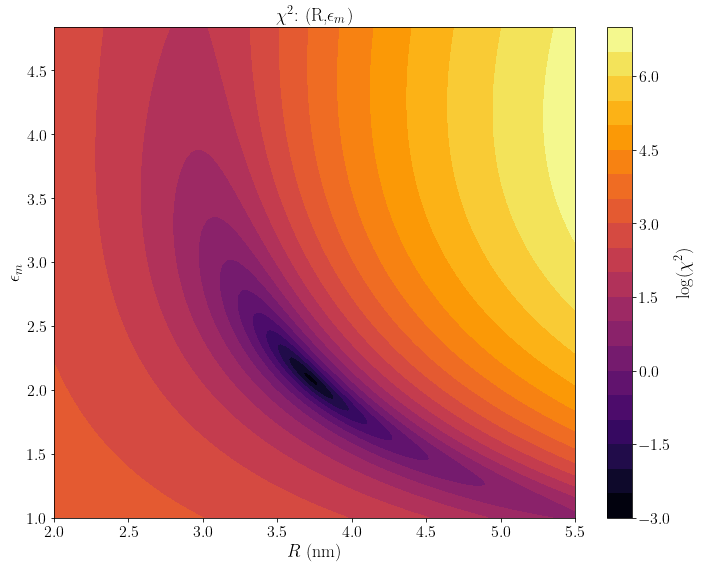

In [106]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10,8))
cp = ax1.contourf(np.array(A_grid), np.array(B_grid)**2, np.log(chisq_values), levels=20, cmap='inferno')
                  #norm=colors.LogNorm(vmin=chisq_values.min(), vmax=chisq_values.max()))

#norm=colors.LogNorm(vmin=chisq_values.min(), vmax=chisq_values.max())
#ax1.set_yscale('log')

#ax1.legend(fontsize=18,title_fontsize=18,loc='best')
ax1.set_title('$\\chi^2$: (R,$\\epsilon_m$)',fontsize=18)
ax1.set_xlabel('$R$ (nm)',fontsize=18)
ax1.set_ylabel('$\\epsilon_m$',fontsize=18)
#ax1.grid(color='0.93')
ax1.tick_params(axis="x", labelsize=16)
ax1.tick_params(axis="y", labelsize=16)

colbar = plt.colorbar(cp)
colbar.set_label('$\\log(\\chi^2)$',fontsize=18)
colbar.ax.tick_params(labelsize=16)

if not os.path.isdir('./images'):
        os.mkdir('./images')
        
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.tight_layout()
plt.savefig('images/2_chisquare.pdf', format='pdf')

In [107]:
# Compute FILLING FRACTION
rho_star = rho
R_star   = a
f = rho_star * 4/3 * np.pi * R_star**3 * np.power(1/10,9)
print(f)

2.1580433604279906e-06



**GANS**

In [108]:
# Limit the fit range 
np_data_f = np_data[np_data['lam(nm)']>= 400]  
np_data_f = np_data_f[np_data_f['lam(nm)']<= 600]

min chi_square: 0.11179556092186145
index min chi_square index: 2197
a= 6.636363636363637
b= 1.97979797979798
Centroid: 527.0
1.9065916540796142
Centroid: 527.0


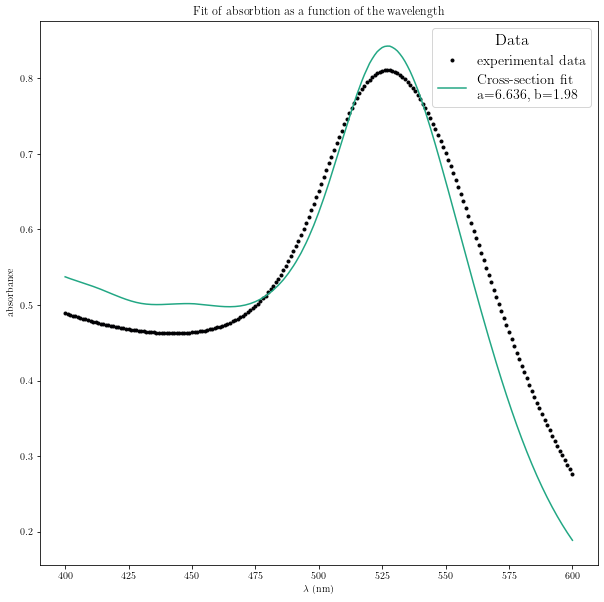

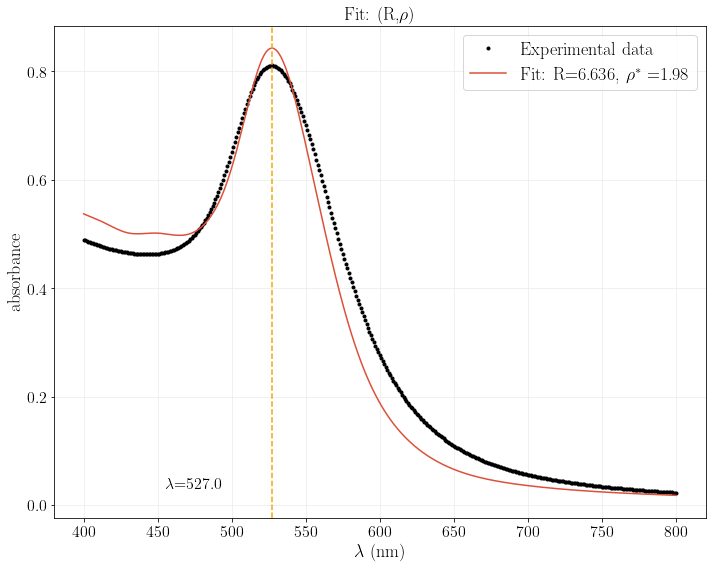

In [109]:
# R and rho

#Define the function for the fit R and rho
def cross_section_rho(x,a,b,bool_lim=False):  # a = R, b=rho
    
    omega = 2 * np.pi * c_speed / x
    
    epsm = 1.33**2#1.43*1.43 #1.33*1.33 
    
    if bool_lim==True:
        eps_1 = np.array( np_data_f['eps1'] )
        eps_2 = np.array( np_data_f['eps2'] )
    if bool_lim==False:
        eps_1 = np.array( np_data['eps1'] )
        eps_2 = np.array( np_data['eps2'] )
        
    eps1 = eps_1_corr(eps_1,omega,a)
    eps2 = eps_2_corr(eps_2,omega,a)
    
    const1  = 1/3 * 4/3 * np.pi * 1/c_speed
    const2 = np.log10(np.e) * np.power(10.,7) * np.power(1/10,9) # L'ultimo valore è in piùùùù
    
    #a1 = 23.955176683359777 # Major axis
    #a2 = 20.15448533785579  # Minor axis
    #ratio=1.2984
    ecc = np.sqrt( 1 - (1/1.2984)**2 )
    L1  = (1-ecc**2)/ecc**2 * ( 1/(2*ecc) * np.log((1+ecc)/(1-ecc)) - 1)
    L2  = (1-L1)/2
    L3  = L2
    
    summation = eps2/L1**2 / ( ( eps1 + epsm * (1-L1)/L1)**2 + eps2**2)   +  2 * eps2/L2**2 / ( ( eps1 + epsm * (1-L2)/L2)**2 + eps2**2)
    
    sigma = const1 * const2 * b * omega * np.power(epsm,3/2) * np.power(a,3) * summation
    
    return sigma

#R_list = np.linspace(3, 10, num=100)
R_list = np.linspace(6., 9., num=100)
rho_list = np.linspace(1.,2., num=100)

x = np.array( np_data_f['lam(nm)'] )
y = np.array( np_data_f['abs'] )

error = 1/y

chi_list = [] 
a_list   = []
b_list   = []


for i in range(len(R_list)):
    for j in range(len(rho_list)):
        chisq = np.sum( np.power( y - cross_section_rho(x,R_list[i],rho_list[j],bool_lim=True), 2)  /(np.power(error,2)) )
        
        chi_list.append(chisq)
        a_list.append(R_list[i])
        b_list.append(rho_list[j])

        
min_chi       =  min(chi_list)
index_min_chi = np.argmin(chi_list)
a             = a_list[index_min_chi]
b             = b_list[index_min_chi]

print('min chi_square:', min_chi)
print('index min chi_square index:', index_min_chi)
print('a=',a)
print('b=',b)

# Plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10,10))

ax1.plot(x,y,'.',color=palette.inferno(6)[0], label= 'experimental data')
string= 'Cross-section fit \n a='+str(round(a,3))+', b='+str(round(b,3))
ax1.plot(x,cross_section_rho(x,a,b,bool_lim=True),'',color=palette.viridis(6)[3], label=string)

ax1.legend(title='Data',fontsize=14,title_fontsize=16,loc='upper left')
ax1.set_title('Fit of absorbtion as a function of the wavelength')
ax1.set_xlabel('$\lambda$ (nm)')
ax1.set_ylabel('absorbance')
ax1.grid(color='0.93')

ax1.legend(title='Data',fontsize=14,title_fontsize=16,loc='upper right')
ax1.set_title('Fit of absorbtion as a function of the wavelength')
ax1.set_xlabel('$\lambda$ (nm)')
ax1.set_ylabel('absorbance')
ax1.grid(color='0.93')



## Plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10,8))
#
ax1.plot(np_data['lam(nm)'],np_data['abs'],'.',color=palette.inferno(6)[0], label= 'Experimental data')
string= 'Fit:  R='+str(round(a,3))+', $\\rho^*$ ='+str(round(b,3))
#ax1.plot(np_data['lam(nm)'],cross_section_rho(np_data['lam(nm)'], 5.3,4.05),'',color='red',label=string)
#ax1.plot(np_data['lam(nm)'],cross_section_rho(np_data['lam(nm)'], 6.6,2.),'',color=palette.viridis(6)[3],label=string)
ax1.plot(np_data['lam(nm)'],cross_section_rho(np_data['lam(nm)'], a, b),'',color=palette.inferno(6)[3],label=string)
ax1.legend(fontsize=18,title_fontsize=18,loc='best')
ax1.set_title('Fit: (R,$\\rho$)',fontsize=18)
ax1.set_xlabel(r'$\lambda$ (nm)',fontsize=18)
ax1.set_ylabel(r'absorbance',fontsize=18)
ax1.grid(color='0.93')
ax1.tick_params(axis="x", labelsize=16)
ax1.tick_params(axis="y", labelsize=16)

# Max centroid
id_centr = np.argmax(cross_section_rho(np_data['lam(nm)'], a, b))
centr = np_data['lam(nm)'][id_centr]
print('Centroid:', centr)
ax1.axvline(x=centr,ls='--',color=palette.inferno(6)[4])
s = '$\\lambda$='+ str(centr)
plt.text(455, 0.03, s, fontsize=16)


if not os.path.isdir('./images'):
        os.mkdir('./data1/images')
        
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.tight_layout()
plt.savefig('images/1_fit_GANS.pdf', format='pdf')


val = np.sum( np.power( y - cross_section_rho(x,5.9,3.6,bool_lim=True), 2)  /(np.power(error,2)) )
print(val)    

# Max centroid
id_centr = np.argmax(cross_section_rho(np_data['lam(nm)'], a, b))
print('Centroid:', np_data['lam(nm)'][id_centr])

In [110]:
np.std(b_list)

0.29157646512850627

In [111]:
A_grid, B_grid = np.meshgrid(R_list, rho_list)

chisq_values = np.zeros((len(A_grid),len(B_grid)))

for i in range(len(A_grid)):
    for j in range(len(B_grid)):
        chisq = np.sum( np.power( y - cross_section_rho(x,A_grid[i][j],B_grid[i][j],bool_lim=True), 2)/(np.power(error,2)) )
        chisq_values[i][j] = chisq
        

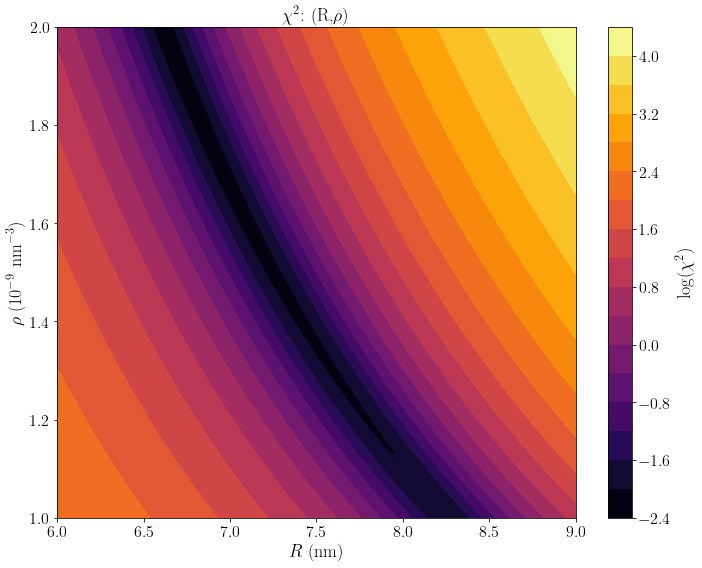

In [112]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10,8))
cp = ax1.contourf(np.array(A_grid), np.array(B_grid), np.log(chisq_values), levels=20, cmap='inferno')
                  #norm=colors.LogNorm(vmin=chisq_values.min(), vmax=chisq_values.max()))

#norm=colors.LogNorm(vmin=chisq_values.min(), vmax=chisq_values.max())
#ax1.set_yscale('log')

#ax1.legend(fontsize=18,title_fontsize=18,loc='best')
ax1.set_title('$\\chi^2$: (R,$\\rho$)',fontsize=18)
ax1.set_xlabel('$R$ (nm)',fontsize=18)
ax1.set_ylabel('$\\rho$ $(10^{-9}$ nm$^{-3})$',fontsize=18)
#ax1.grid(color='0.93')
ax1.tick_params(axis="x", labelsize=16)
ax1.tick_params(axis="y", labelsize=16)

colbar = plt.colorbar(cp)
colbar.set_label('$\\log(\\chi^2)$',fontsize=18)
colbar.ax.tick_params(labelsize=16)

if not os.path.isdir('./images'):
        os.mkdir('./images')
        
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.tight_layout()
plt.savefig('images/1_chisquare_GANS.pdf', format='pdf')

In [113]:
R = a
rho = b

min chi_square: 0.06522881442349171
index min chi_square index: 4035
a= 6.414141414141414
b= 1.3767676767676766
Centroid: 530.0
Centroid: 530.0


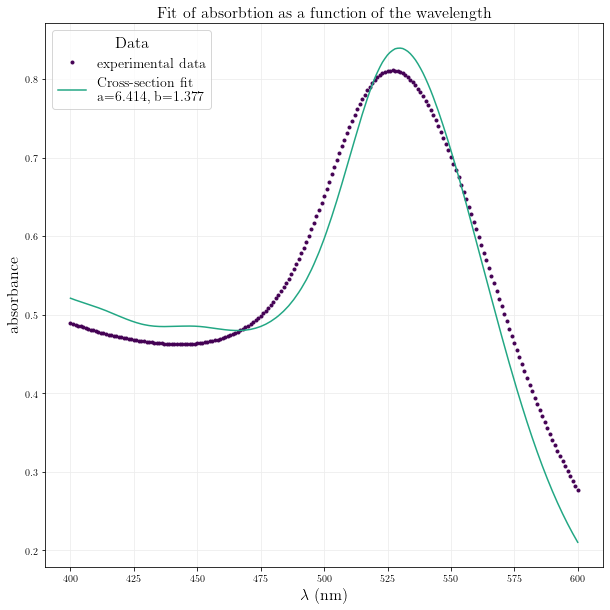

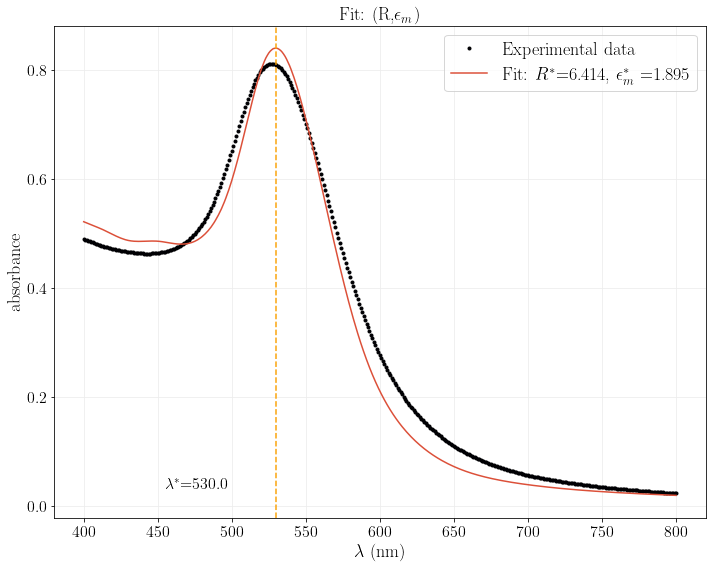

In [114]:
# R and Epsm

#Define the function for the fit R and epsm
def cross_section_epsm(x,a,b,val_rho,bool_lim=False):  # a = R, b = epsm
    
    omega = 2 * np.pi * c_speed / x
    
    rho = val_rho * np.power(1/10,9) # VALORE INSERITO IN PIUUU
    
    if bool_lim==True:
        eps_1 = np.array( np_data_f['eps1'] )
        eps_2 = np.array( np_data_f['eps2'] )
    if bool_lim==False:
        eps_1 = np.array( np_data['eps1'] )
        eps_2 = np.array( np_data['eps2'] )
    
    eps1 = eps_1_corr(eps_1,omega,a)
    eps2 = eps_2_corr(eps_2,omega,a)
    
    const1  = 1/3 * 4/3 * np.pi * 1/c_speed
    const2 = np.log10(np.e) * np.power(10.,7) 
    
    
    ecc = np.sqrt( 1 - (1/1.2984)**2 )
    L1  = (1-ecc**2)/ecc**2 * ( 1/(2*ecc) * np.log((1+ecc)/(1-ecc)) - 1)
    L2  = (1-L1)/2
    L3  = L2
    
    summation = eps2/L1**2 / ( ( eps1 + b**2 * (1-L1)/L1)**2 + eps2**2)   +  2 * eps2/L2**2 / ( ( eps1 + b**2 * (1-L2)/L2)**2 + eps2**2)
    
    sigma = const1 * const2 * rho * omega * np.power(a,3) * np.power((b**2),3/2) * summation
       
    return sigma


R_list = np.linspace(5., 8.5, num=100)
epsm_list = np.linspace(1.2,1.7, num=100)

x = np.array( np_data_f['lam(nm)'] )
y = np.array( np_data_f['abs'] )

error = 1/y

chi_list = [] 
a_list   = []
b_list   = []

for i in range(len(R_list)):
    for j in range(len(epsm_list)):
        chisq = np.sum( np.power( y - cross_section_epsm(x,R_list[i],epsm_list[j],rho,bool_lim=True), 2) /(np.power(error,2)) )
        
        chi_list.append(chisq)
        a_list.append(R_list[i])
        b_list.append(epsm_list[j])

        
min_chi       =  min(chi_list)
index_min_chi = np.argmin(chi_list)
a             = a_list[index_min_chi]
b             = b_list[index_min_chi]

print('min chi_square:', min_chi)
print('index min chi_square index:', index_min_chi)
print('a=',a)
print('b=',b)

# Plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10,10))
#
ax1.plot(x,y,'.',color=palette.viridis(6)[0], label= 'experimental data')
string= 'Cross-section fit \n a='+str(round(a,3))+', b='+str(round(b,3))
ax1.plot(x,cross_section_epsm(x,a,b,rho,bool_lim=True),'',color=palette.viridis(6)[3], label=string)

ax1.legend(title='Data',fontsize=14,title_fontsize=16,loc='best')
ax1.set_title('Fit of absorbtion as a function of the wavelength',fontsize=16)
ax1.set_xlabel('$\lambda$ (nm)',fontsize=16)
ax1.set_ylabel('absorbance',fontsize=16)
ax1.grid(color='0.93')




## Plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10,8))
#
ax1.plot(np_data['lam(nm)'],np_data['abs'],'.',color=palette.inferno(6)[0], label= 'Experimental data')
string= 'Fit:  $R^*$='+str(round(a,3))+', $\\epsilon_m^*$ ='+str(round(b**2,3))
ax1.plot(np_data['lam(nm)'],cross_section_epsm(np_data['lam(nm)'], a,b,rho),'',color=palette.inferno(6)[3],label=string)

ax1.legend(fontsize=18,title_fontsize=18,loc='best')
ax1.set_title('Fit: (R,$\\epsilon_m$)',fontsize=18)
ax1.set_xlabel('$\lambda$ (nm)',fontsize=18)
ax1.set_ylabel('absorbance',fontsize=18)
ax1.grid(color='0.93')

ax1.tick_params(axis="x", labelsize=16)
ax1.tick_params(axis="y", labelsize=16)

# Max centroid
id_centr = np.argmax(cross_section_epsm(np_data['lam(nm)'], a, b,rho))
centr = np_data['lam(nm)'][id_centr]
print('Centroid:', centr)
ax1.axvline(x=centr,ls='--',color=palette.inferno(6)[4])
s = '$\\lambda^*$='+ str(centr)
plt.text(455, 0.03, s, fontsize=16)

if not os.path.isdir('./images'):
        os.mkdir('./images')
        
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.tight_layout()
plt.savefig('images/2_fit_GANS.pdf', format='pdf')

# Max centroid
id_centr = np.argmax(cross_section_epsm(np_data['lam(nm)'], a,b,rho))
print('Centroid:', np_data['lam(nm)'][id_centr])

In [121]:
ecc

NameError: name 'ecc' is not defined

In [115]:
A_grid, B_grid = np.meshgrid(R_list, epsm_list)

chisq_values = np.zeros((len(A_grid),len(B_grid)))

for i in range(len(A_grid)):
    for j in range(len(B_grid)):
        chisq = np.sum( np.power( y - cross_section_epsm(x,A_grid[i][j],B_grid[i][j],rho,bool_lim=True), 2)/(np.power(error,2)) )
        chisq_values[i][j] = chisq
        

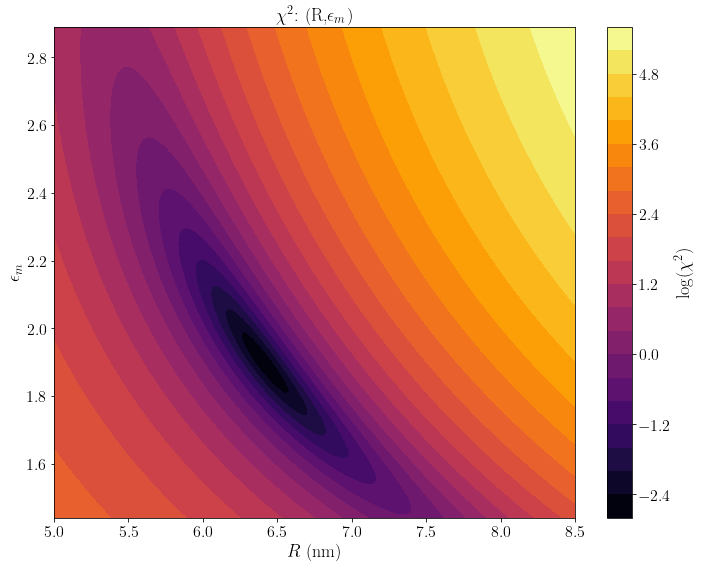

In [116]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10,8))
cp = ax1.contourf(np.array(A_grid), np.array(B_grid)**2, np.log(chisq_values), levels=20, cmap='inferno')
                  #norm=colors.LogNorm(vmin=chisq_values.min(), vmax=chisq_values.max()))

#norm=colors.LogNorm(vmin=chisq_values.min(), vmax=chisq_values.max())
#ax1.set_yscale('log')

#ax1.legend(fontsize=18,title_fontsize=18,loc='best')
ax1.set_title('$\\chi^2$: (R,$\\epsilon_m$)',fontsize=18)
ax1.set_xlabel('$R$ (nm)',fontsize=18)
ax1.set_ylabel('$\\epsilon_m$',fontsize=18)
#ax1.grid(color='0.93')
ax1.tick_params(axis="x", labelsize=16)
ax1.tick_params(axis="y", labelsize=16)

colbar = plt.colorbar(cp)
colbar.set_label('$\\log(\\chi^2)$',fontsize=18)
colbar.ax.tick_params(labelsize=16)

if not os.path.isdir('./images'):
        os.mkdir('./images')
        
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.tight_layout()
plt.savefig('images/2_chisquare_GANS.pdf', format='pdf')

In [117]:
# Compute FILLING FRACTION
rho_star = rho
R_star   = a
f = rho_star * 4/3 * np.pi * R_star**3 * np.power(1/10,9)
print(f)

2.188391796758022e-06


In [118]:
np.std(a_list)

1.0205176279497719

In [120]:
np.std(b_list)

0.14578823256425313

In [129]:
ecc=np.sqrt(1-(1/1.2984)**2)

In [128]:
(np.sqrt(1.895)-1.33)/1.33*100

3.5030067514000294

In [131]:
ar=1.2984


In [144]:
np.sqrt(1-(1/ar)**2)

0.6378281889612814

In [142]:
err=np.sqrt(((-np.power(1-np.power(1/ar,2), 3/2)*np.power(1/ar,3))**2)*(0.008**2))

In [143]:
err

0.0009483651661039234

In [147]:
(1.33**2-1.895)/1.33**2

-0.07128724065803599